## Credit Risk Data Modelling with Multi-layer Perceptron and Support Vector Machine 

Disclaimer: 
<br> This solution is showcased to share my understanding of the problem and my own approach to it.
<br> This solution is not intended for any general application.

#### For questions, suggestions and further details, please feel free to contact me at juan-carlos.ramirez@warwick.ac.uk

---------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.metrics as skmetrics
from matplotlib.colors import ListedColormap
from sklearn import datasets, linear_model, svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
sns.set_theme() # Seaborn template
sns.set_palette(palette="crest") # Default colors
plt.rcParams['figure.figsize'] = [16, 8] # Default to bigger plots
pd.set_option('display.float_format', lambda x: '%.2f' % x) # display 2 decimals by default
rnd_seed = 666 # Random seed used across the notebook

------------

## Motivation

Our motivation in the present notebook will be to examine different Machine Learning approaches using the German Credit Risk Dataset hosted on Kaggle and the UC Irvine Machine Learning Repository. Each entry represents an individual seeking credit. Every client has been classified as a good or bad credit risk according to the set of attributes (features). The goal of this part of the project is to train a Support Vector Machine classifier on this dataset to predict credit risk.

-----------

## Data Exploration

By making use of the "german.data-numeric-withheader.csv" which contains data of several credit applicants in Germany, we want to check that the data is sensible, and we will do so by exploring the first 5 rows of the **DataFrame**


In [2]:
# Step 1: Read the Data
CreditData = pd.read_csv("4.1 SVC vs MLPC credit risk data.csv") 
CreditData.head(5)

,CREDITRATING,BalanceCheque,Loan_NurnMonth,CreditHistory,CreditAmt,SavingsBalance,Mths_employ,PersonStatusSex,PresentResidence,Property,...,ForeignWorker,Purpose_CarNew,Purpose_CarOld,otherdebtor_noneVsGuar,otherdebt_coapplVsGuar,house_rentVsFree,house_ownsVsFree,job_unemployedVsMgt,jobs_unskilledVsMgt,job_skilledVsMgt
0,-1,1,6,4,12,5,5,3,4,1,...,1,0,0,1,0,0,1,0,0,1
1,1,2,48,1,60,1,3,2,2,1,...,1,0,0,1,0,0,1,0,0,1
2,-1,4,12,4,21,1,4,3,3,1,...,1,0,0,1,0,0,1,0,1,0
3,-1,1,42,1,79,1,4,3,4,2,...,1,0,0,0,0,0,0,0,0,1
4,1,1,24,3,49,1,3,3,4,4,...,1,1,0,1,0,0,0,0,0,1


From the previous **DataFrame**, we see choose four arbitrary features to review them, also, notice that the variable CREDITRATING takes only two values, -1 and 1, which will be interpreted as **Bad Credit** and **Good Credit** for the rest of the notebook.

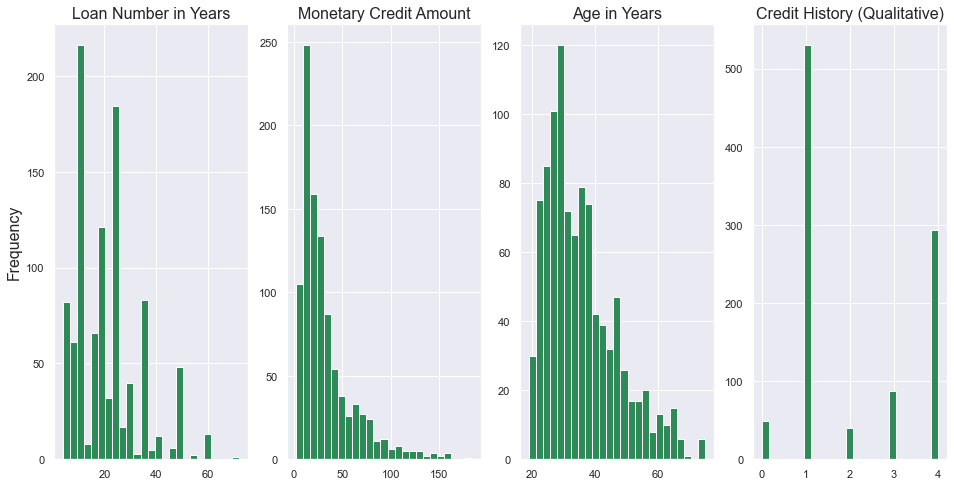

In [3]:
# Step 2: Separate Desing Matrix and Target
DesingMatrix = CreditData.drop(['CREDITRATING'],axis=1)
Target = CreditData['CREDITRATING']

# Step 3: Analyze relevant features of the design matrix
PltFeatures = {'Loan_NurnMonth':'Loan Number in Years',
               'CreditAmt':'Monetary Credit Amount',
               'AgeInYears':'Age in Years',
               'CreditHistory':'Credit History (Qualitative)'}
i = 0
f, axes = plt.subplots(1, 4)
for f in PltFeatures.keys():
    DesingMatrix[f].hist(ax=axes[i],color='seagreen',bins=25)
    axes[i].set_title(PltFeatures[f],fontsize=16)
    i += 1
axes[0].set_ylabel('Frequency',fontsize=16)
plt.show()

The **Histograms** display the behaviour of four features with the following meanings:

- AgeInYears = Age of clients

- Loan_NumMonth = Duration of the loan in Months.

- CreditAmt = Size of the loan requested by the client.

- CreditHistory (Qualitative) = Client's credit behaviour, with:
    - 0: No credit history
    - 1: Current bank credits properly paid
    - 2: All banks credits properly paid
    - 3: Delay in credit payment
    - 4: Critical Account in current or other banks
    
There is nothing unusual in our observations, so we proceed to perform a sanity check by calculating a cross validation score of the Support Vector Classifier model with the default parameters and without scaling.

We also create our testing and training partitions here, which we will choose to be (1/3) and (2/3)

In [4]:
# Step 4: Perform test-train split
X_train, X_test, y_train, y_test = train_test_split(DesingMatrix, Target, test_size=(1/3), random_state=rnd_seed)

# Step 5: Sanity check by doing cross validation on the unscaled data
clf = svm.SVC()
fit = clf.fit(X_train, y_train)
y_pred = fit.predict(X_test)
# Mean Cross validation score
scores = cross_val_score(clf,X_train,y_train)  
print('Not tunned model score: '+str(round(fit.score(X_test, y_test),4)))

Not tunned model score: 0.6916


A score of 69% is good enough to believe that our data allows the model to perform decently without doing extra work, so now we turn to the task of tunning the models.

---------

## Training & Testing Sets

We will try our models with three data options, Unscaled data, scaled using Sklearn's **StandarScaler** and using Sklearn's **MinMaxScalers**


In [5]:
# Step 6: Scaling the data with the Standard Scaler and the MinMax Scaler
# Store Unscaled X
ModelData = {'Unscaled':{},'Standard':{},'MinMax':{}}
ModelData['Unscaled']['Train'] = X_train
ModelData['Unscaled']['Testing'] = X_test
# Standard Scaler
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
ModelData['Standard']['Train'] = pd.DataFrame(scaler.transform(X_train),index=X_train.index,columns=X_train.columns)
ModelData['Standard']['Testing'] = pd.DataFrame(scaler.transform(X_test),index=X_test.index,columns=X_test.columns)
# MinMax Scaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
ModelData['MinMax']['Train'] = pd.DataFrame(scaler.transform(X_train),index=X_train.index,columns=X_train.columns)
ModelData['MinMax']['Testing'] = pd.DataFrame(scaler.transform(X_test),index=X_test.index,columns=X_test.columns)

---------

## Data pre-processing: Support Vector Classifier

We start by tunning the Support Vector Classifier model, by choosing an appropriate data set, a kernel and the hyperparameters.
A short introduction of how to use the Support Vector Classifier can be found in [1]

In [6]:
# Step 7: Calculate cross validation scores for 9 configurations on the SVC model
SVC_Scores = {}
Kernel_options = ['rbf', 'poly', 'linear']
print('Cross validation scores for the Support Vector Classifier')
print('-----------------------------------------------------------')
for k in Kernel_options:
    SVC_Scores[k] = {}
    for d in ModelData.keys():
        clf = svm.SVC(kernel=k)
        clf.fit(ModelData[d]['Train'], y_train)
        y_pred = clf.predict(ModelData[d]['Testing'])
        SVC_Scores[k][d] = cross_val_score(clf,ModelData[d]['Train'],y_train)
        print('     '+ d+' scaling with '+k+' kernel: '+\
              str(round(SVC_Scores[k][d].mean(),2))+' +\- '+ str(round(SVC_Scores[k][d].std(),2)))
    print('-----------------------------------------------------------')

Cross validation scores for the Support Vector Classifier
-----------------------------------------------------------
     Unscaled scaling with rbf kernel: 0.72 +\- 0.01
     Standard scaling with rbf kernel: 0.76 +\- 0.01
     MinMax scaling with rbf kernel: 0.75 +\- 0.01
-----------------------------------------------------------
     Unscaled scaling with poly kernel: 0.73 +\- 0.01
     Standard scaling with poly kernel: 0.73 +\- 0.03
     MinMax scaling with poly kernel: 0.72 +\- 0.01
-----------------------------------------------------------
     Unscaled scaling with linear kernel: 0.75 +\- 0.02
     Standard scaling with linear kernel: 0.76 +\- 0.02
     MinMax scaling with linear kernel: 0.76 +\- 0.01
-----------------------------------------------------------


We select the **MinMax** scaled data and the **linear kernel**, since the combination offers the maximum score with the least standard deviation of the combinations and also, for the sake of simplicity, the **linear kernel** got some interesting particularities which we will talk about later.

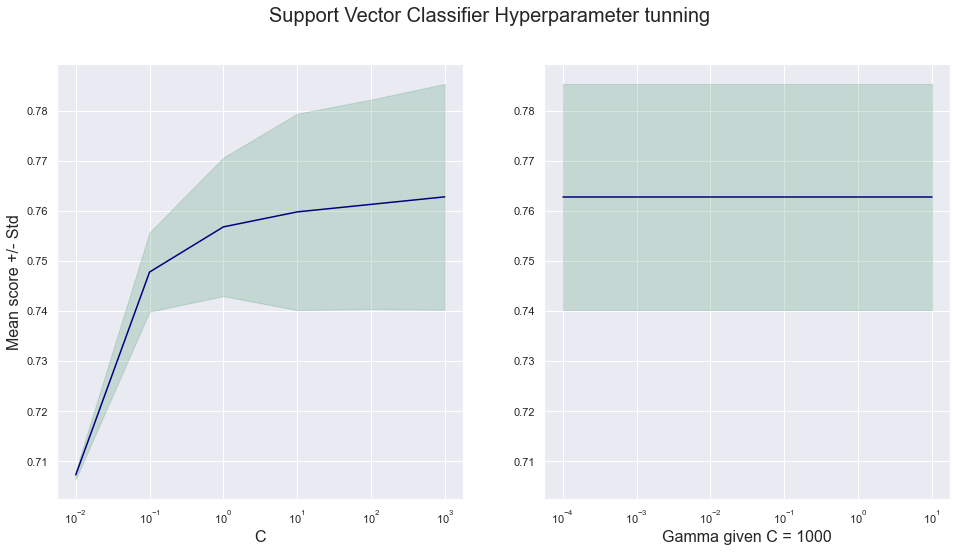

In [7]:
# Step 9: Hyperparameter tunning
fig = plt.figure()
fig.suptitle('Support Vector Classifier Hyperparameter tunning',fontsize=20)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

C_vals = [.01, .1, 1, 10, 100, 1000]
Ncases = len(C_vals)
score_mean = np.zeros(Ncases)
score_std = np.zeros(Ncases)
for k in range(Ncases):
    clf = svm.SVC(C=C_vals[k],kernel='linear')
    scores = cross_val_score(clf,ModelData['MinMax']['Train'],y_train)  
    score_mean[k] = scores.mean()
    score_std[k] = scores.std()

ax1.semilogx(C_vals,score_mean,color='navy')
ax1.fill_between(C_vals,score_mean-score_std,score_mean+score_std,alpha=0.2,color='seagreen')
ax1.set_ylabel("Mean score +/- Std", fontsize="16")
ax1.set_xlabel("C", fontsize="16")

g_vals = [.0001, .001, .01, 0.1, 1, 10]
Ncases = len(g_vals)
score_mean = np.zeros(Ncases)
score_std = np.zeros(Ncases)
for k in range(Ncases):
    clf = svm.SVC(C=1000,gamma=g_vals[k],kernel='linear')
    scores = cross_val_score(clf,ModelData['MinMax']['Train'],y_train)
    score_mean[k] = scores.mean()
    score_std[k] = scores.std()

ax2.semilogx(g_vals,score_mean,color='navy')
ax2.fill_between(g_vals,score_mean-score_std,score_mean+score_std,alpha=0.2,color='seagreen')
ax2.set_xlabel("Gamma given C = 1000", fontsize="16")

ax1.get_shared_y_axes().join(ax1, ax2)
plt.subplots_adjust(hspace=0.001)
ax2.autoscale()
plt.show()

Here, our decision is simple, as we will leave our parameter **C** equal to **1000**. Moreover, we see that the parameter Gamma becomes irrelevant when we use a **linear kernel**, which makes intuitive sense since **Gamma** defines the curvature of the decision boundary of the classifier, which is irrelevant for the linear kernel (here the decision boundary is a straight line).

---------

## Data modelling: Multi-layer Perceptron Classifier

Next, we tune the Multi-layer Perceptron Classifier to our data. Again, we start by choosing an adequate data set (no need for a kernel in this model). A short introduction of how to use the Multi-layer Perceptron can be found in [2]


In [8]:
# Step 10: Calculate cross validation scores for the Multi-layer Perceptron
MLP_Scores = {}
print('Cross validation scores for the Multi-layer Perceptron')
print('-----------------------------------------------------------')
clf = MLPClassifier(learning_rate_init=0.01, max_iter=5000, random_state=rnd_seed)
for d in ModelData.keys():
    clf.fit(ModelData[d]['Train'], y_train)
    y_pred = clf.predict(ModelData[d]['Testing'])
    SVC_Scores[d] = cross_val_score(clf,ModelData[d]['Train'],y_train)
    print('     '+ d+' scaling: '+\
          str(round(SVC_Scores[d].mean(),2))+' +\- '+ str(round(SVC_Scores[d].std(),2)))
print('-----------------------------------------------------------')

Cross validation scores for the Multi-layer Perceptron
-----------------------------------------------------------
     Unscaled scaling: 0.77 +\- 0.01
     Standard scaling: 0.69 +\- 0.02
     MinMax scaling: 0.7 +\- 0.02
-----------------------------------------------------------


Here, we stay with the **Unscaled** data, since it is clearly the method with the highest score and also the least standard deviation.

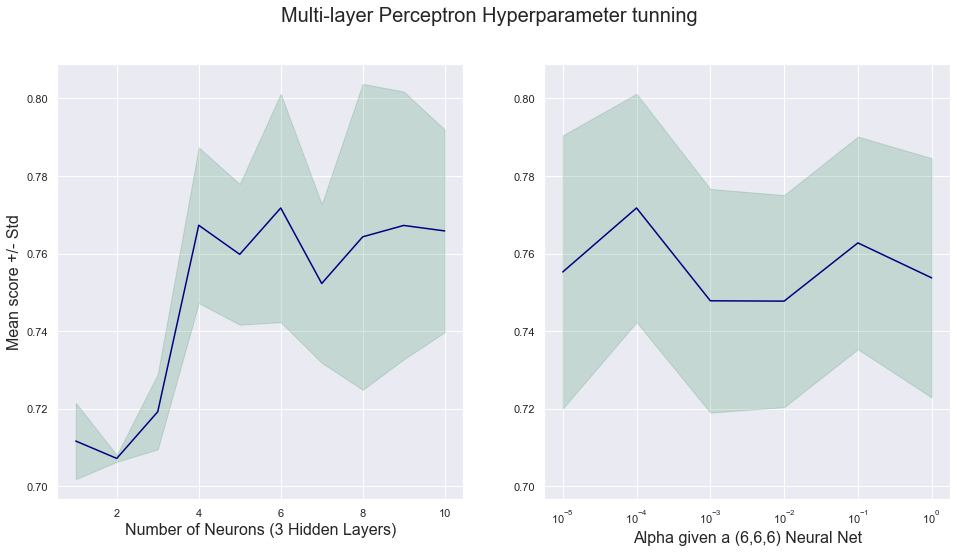

In [9]:
# Step 11: Hyperparameter tunning for the Multi-layer Perceptron
fig = plt.figure()
fig.suptitle('Multi-layer Perceptron Hyperparameter tunning',fontsize=20)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

Neurons = range(1,11)
Ncases = len(Neurons)
score_mean = np.zeros(Ncases)
score_std = np.zeros(Ncases)
for k in range(Ncases):
    # 3 layers required since the shape of hidden_layer_sizes=( , , ,) (Does not include input/output layers)
    clf = MLPClassifier(hidden_layer_sizes=(Neurons[k],Neurons[k],Neurons[k]),
                        learning_rate_init=0.01, max_iter=5000, random_state=rnd_seed)
    scores = cross_val_score(clf,ModelData['Unscaled']['Train'],y_train)  
    score_mean[k] = scores.mean()
    score_std[k] = scores.std()

ax1.plot(Neurons,score_mean,color='navy')
ax1.fill_between(Neurons,score_mean-score_std,score_mean+score_std,alpha=0.2,color='seagreen')
ax1.set_ylabel("Mean score +/- Std", fontsize="16")
ax1.set_xlabel("Number of Neurons (3 Hidden Layers)", fontsize="16")

k = np.arange(-5,1)
alphas = 10.**k
Ncases = len(alphas)
score_mean = np.zeros(Ncases)
score_std = np.zeros(Ncases)
for k in range(Ncases):
    # 3 layers required since the shape of hidden_layer_sizes=( , , ,) (Does not include input/output layers)
    clf = MLPClassifier(hidden_layer_sizes=(6,6,6), alpha=alphas[k],
                        learning_rate_init=0.01, max_iter=5000, random_state=rnd_seed)
    scores = cross_val_score(clf,ModelData['Unscaled']['Train'],y_train)
    score_mean[k] = scores.mean()
    score_std[k] = scores.std()

ax2.semilogx(alphas,score_mean,color='navy')
ax2.fill_between(alphas,score_mean-score_std,score_mean+score_std,alpha=0.2,color='seagreen')
ax2.set_xlabel("Alpha given a (6,6,6) Neural Net", fontsize="16")

ax1.get_shared_y_axes().join(ax1, ax2)
ax2.autoscale()
plt.show()

For the sake of computational efficiency, we choose to use a **Neural Net** with **three hidden layers**, for which we assume each layer contains the same number of **Neurons**, we set the number of **Neurons** to **six**, since that hyperparameter gives the highest score with the least number of **Neurons**. Also, given our **Neural Net** structure decision, we set **Alpha** to be the default value, which we see by comparing the left plot with the right plot that alpha makes no real improvement.

-------

## Target Prediction: Support Vector Machine Classifier Vs Multi-layer Perceptron Classifier 

At last, we turn our attention to the predictive power of our tunned models.

Performance Scores
------------------------------------------------
Support Vector Machine Classifier
     Model Score:  0.7275
     Cross-Validation Score:  0.76 +\- 0.02
------------------------------------------------
Multi-Layer Perceptron Classifier
     Model Score:  0.7096
     Cross-Validation Score:  0.77 +\- 0.03
------------------------------------------------


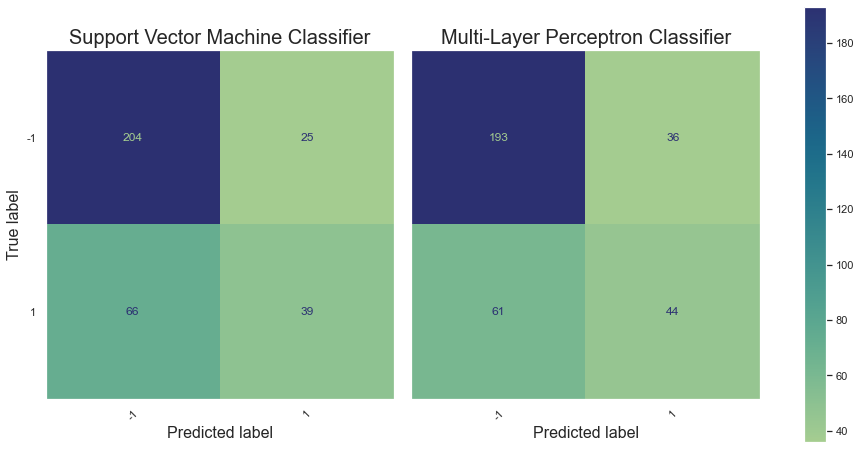

In [10]:
# Step 12: Target prediction comparation between SVC and MLPC
# Dictionary with the models we want and another one to store the predictions
classifiers = {
    "Support Vector Machine Classifier": svm.SVC(C=1000, random_state=rnd_seed, kernel='linear'),
    "Multi-Layer Perceptron Classifier": MLPClassifier(hidden_layer_sizes=(6,6,6), learning_rate_init=0.01,
                                                       max_iter=5000, random_state=rnd_seed),
}
DataClf = {
    "Support Vector Machine Classifier": 'MinMax',
    "Multi-Layer Perceptron Classifier": 'Unscaled',
}
FitData = {}

print('Performance Scores')
print('------------------------------------------------')

f, axes = plt.subplots(1, 2, sharey='row')
for i, (key, classifier) in enumerate(classifiers.items()):
    FitData[key] = classifier.fit(ModelData[DataClf[key]]['Train'], y_train)
    y_pred = FitData[key].predict(ModelData[DataClf[key]]['Testing'])
    SVC_Scores = cross_val_score(classifier,ModelData[DataClf[key]]['Train'],y_train)
    
    print(str(key))
    print('     Model Score: ',round(FitData[key].score(ModelData[DataClf[key]]['Testing'], y_test),4))
    print('     Cross-Validation Score: ',str(round(SVC_Scores.mean(),2))+' +\- '+ str(round(SVC_Scores.std(),2)))
    print('------------------------------------------------')
    
    cm = skmetrics.confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot(ax=axes[i], xticks_rotation=45, cmap='crest')
    disp.ax_.set_title(key,fontsize=20)
    disp.ax_.grid(False)
    disp.im_.colorbar.remove()
    disp.ax_.set_ylabel('True label',fontsize=16)
    disp.ax_.set_xlabel('Predicted label',fontsize=16)
    if i!=0:
        disp.ax_.set_ylabel('')

plt.subplots_adjust(wspace=0.05)
f.colorbar(disp.im_, ax=axes)
plt.show()

The performance of the models, although by a small margin, shows that the **Support Vector Machine Classifier (SVC)** performs better than the **Multi-Layer Perceptron (MLP)**. Moreover, we see some things that are very interesting here.

First, the **SVC** does have a slightly better performance over the **MLP** in our test data, which is surprising because the **SVC** model under a **Linear kernel** can be considered "less sophisticated" compared to the a **MLP** model with **Three hidden layers with 6 Neurons each**

On the other hand, the **MLP** model cross-validation score is slightly higher than the **SVC** model, which is not consistent with the actual performance on the test data, this tells us than even if the cross-validation scores help us set our hyperparameters, they do not give us the complete picture of the performance of the models.

Overall, even if the **SVC** model seems slightly better than the **MPL** we must also take into account that randomness is still an important factor and therefore we cannot simply say that **SVC** is better than **MPL**. Furthermore, model selection remains a task highly sensible, both on the data and on the Analyst's judgment and expertise.

----------

## References

[1]: Scikit-Learn, Support Vector Regression, https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html, (accesed: 12/08/2021)
<br>[2]: Scikit-Learn, Multi-Layer Perceptron, https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html, (accesed: 12/08/2021)